# With DRMS

In [31]:
import drms
import requests
import seaborn as sns
import timm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from comet_ml import API
import numpy as np
from matplotlib import pyplot as plt
import os
from astropy.io import fits
import sys
sys.path.insert(0,'../')
from arccnet.models import dataset_utils as ut_d
from arccnet.models import train_utils as ut_t
from arccnet.visualisation import utils as ut_v
from arccnet.models.cutouts import inference
from arccnet.models import labels as lbls

import pandas as pd
from pathlib import Path

In [67]:
keys_list = ['T_REC', 'NOAA_AR', 'LON_FWT', 'TOTUSJZ',
       'SAVNCPP', 'TOTPOT', 'TOTUSJH', 'ABSNJZH', 'USFLUX', 'R_VALUE',
       'AREA_ACR', 'SHRGT45', 'MEANPOT', 'MEANGBZ', 'MEANJZH', 'MEANSHR',
       'MEANJZD', 'MEANALP', 'MEANGBT', 'MEANGAM', 'MEANGBH', 'NACR', 'SIZE',
       'NPIX', 'OBS_VR', 'CROTA2', 'CRPIX1', 'CRPIX2', 'CDELT1', 'CDELT2',
       'CRVAL1', 'CRVAL2', 'QUALITY', 'NOAA_NUM', 'HARPNUM']

In [81]:
jsoc = drms.Client()
ds = jsoc.series(r'hmi\.sharp_')

keys,segments = jsoc.query('hmi.sharp_cea_720s[][2024.05.2_00:00:00/264h][? NOAA_ARS ~ "13664" ?]',key=keys_list,seg='magnetogram')

In [88]:
idx = 820
keys.iloc[idx]

T_REC           2024.05.09_09:36:00_TAI
NOAA_AR                           13664
LON_FWT                        25.91888
TOTUSJZ               196330000000000.0
SAVNCPP               128518100000000.0
TOTPOT      3568398000000000210239488.0
TOTUSJH                       13767.039
ABSNJZH                        4053.925
USFLUX       100529599999999993708544.0
R_VALUE                           5.712
AREA_ACR                    4258.723633
SHRGT45                          48.013
MEANPOT                        20746.61
MEANGBZ                         129.548
MEANJZH                        0.031302
MEANSHR                          46.191
MEANJZD                        0.062035
MEANALP                        0.049027
MEANGBT                         108.161
MEANGAM                            52.8
MEANGBH                           74.68
NACR                              81571
SIZE                       25527.681641
NPIX                             285082
OBS_VR                      -733.605494


http://jsoc.stanford.edu/SUM85/D1753921941/S00000/magnetogram.fits


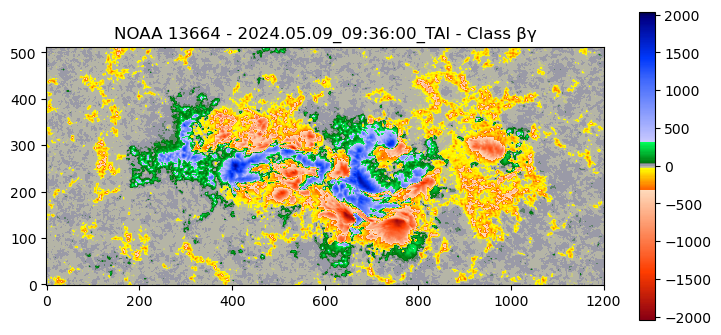

In [100]:
url = 'http://jsoc.stanford.edu' + segments.magnetogram[idx]
print(url)
photosphere_image = fits.open(url)   
data = np.array(photosphere_image[1].data, dtype=np.float32)

plt.figure(figsize=(9,4))
max_val = np.max(np.abs([np.max(data), np.min(data)]))
plt.imshow(data, origin='lower', cmap=ut_v.magnetic_map, vmin = -max_val, vmax = max_val)
plt.title( f"NOAA {keys.iloc[idx]['NOAA_AR']} - {keys.iloc[idx]['T_REC']} - Class βγ")
plt.colorbar()

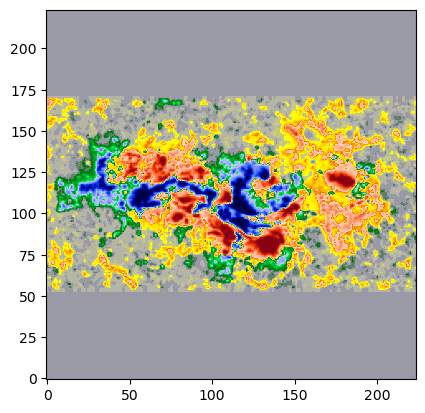

In [101]:
def preprocess_fits_data(image_data, hardtanh=True, target_height=224, target_width=224):
    image_data = np.nan_to_num(image_data, nan=0.0)
    if hardtanh:
        image_data = ut_v.hardtanh_transform_npy(image_data, divisor=800, min_val=-1.0, max_val=1.0)
    image_data = ut_v.pad_resize_normalize(image_data, target_height=target_height, target_width=target_width)
    return torch.from_numpy(image_data).unsqueeze(0)

batch = preprocess_fits_data(data[:,150:1150])
plt.imshow(batch.squeeze(0), origin='lower', cmap=ut_v.magnetic_map, vmin = -1, vmax = 1)

In [102]:
output_dir = Path(ut_d.__file__).parent.resolve() / 'trained_models'
model_name = 'vit_small_patch16_224'
model_version = '1.0.0'
model_path =  output_dir / f"{model_name}-{model_version}.pth"
api = API()

In [103]:
inference.download_model(api, 'arcaff', model_name, model_version, model_path)

Model file already exists at /home/edoardo/Code/ARCAFF/ARCCnet/arccnet/models/trained_models/vit_small_patch16_224-1.0.0.pth. 
Skipping download.


In [104]:
num_classes = 5
model = timm.create_model(model_name, pretrained=False, num_classes=num_classes, in_chans=1)
device = torch.device("cuda")
state_dict = torch.load(model_path, weights_only=True, map_location=device)
model.load_state_dict(state_dict)
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [105]:
model.eval()
with torch.no_grad():
    input = batch.unsqueeze(0).to(device)
    outputs = model(input)
probabilities = torch.softmax(torch.tensor(outputs.cpu().numpy()), dim=1).numpy()
probabilities

array([[1.3098225e-04, 3.3185046e-04, 1.2282567e-04, 8.7998984e-03,
        9.9061441e-01]], dtype=float32)

In [106]:
labels_v = ["QS", "IA", "Alpha", "Beta", "Beta-Gamma"]
greek_labels = lbls.convert_to_greek_label(labels_v)
df = pd.DataFrame(probabilities, columns=greek_labels)
print(df)

         QS        IA         α       β       β-γ
0  0.000131  0.000332  0.000123  0.0088  0.990614


In [29]:
data_folder = os.getenv('ARCAFF_DATA_FOLDER', '/Volumes/ExtremePro/ARCAFF/data')
dataset_folder='arccnet-cutout-dataset-v20240715'
df_file_name='cutout-mcintosh-catalog-v20240715.parq'

batch_size = 16
num_workers = 12

label_mapping = lbls.qs_ia_a_b_bg_mapping

df, AR_df = ut_d.make_dataframe(data_folder, dataset_folder, df_file_name)
df, df_du = ut_d.undersample_group_filter(
    df, label_mapping, long_limit_deg=60, 
    undersample=True, buffer_percentage=0.1)
fold_df = ut_d.split_data(df_du, label_col='grouped_labels', group_col='number', random_state=42)
df = ut_d.assign_fold_sets(df, fold_df)
df_test = df[df[f'Fold {1}'] == 'test']
test_dataset = ut_t.FITSDataset(data_folder, dataset_folder, df=df_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [30]:
test_loss = 0
total_correct = 0
total_images = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.long()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy = total_correct / total_images
test_precision, test_recall, test_f1, cm_test, report_df = ut_t.calculate_metrics(all_labels, all_preds)
print("Confusion Matrix:")
print(cm_test)
print("Classification Report:")
print(report_df)

Confusion Matrix:
[[1556   49    3    4    0]
 [  21  345   38   15    1]
 [   0   45  306   87    1]
 [   3   53  145  711  104]
 [   0    3    0   57  144]]
Classification Report:
              precision    recall  f1-score      support
0              0.984810  0.965261  0.974937  1612.000000
1              0.696970  0.821429  0.754098   420.000000
2              0.621951  0.697039  0.657358   439.000000
3              0.813501  0.699803  0.752381  1016.000000
4              0.576000  0.705882  0.634361   204.000000
accuracy       0.829585  0.829585  0.829585     0.829585
macro avg      0.738646  0.777883  0.754627  3691.000000
weighted avg   0.839149  0.829585  0.831950  3691.000000


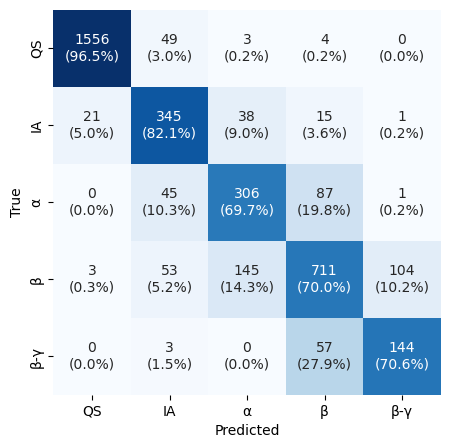

In [109]:
# Calculate the row percentages
row_sums = cm_test.sum(axis=1, keepdims=True)
cm_percentage = cm_test / row_sums * 100

# Create a custom annotation that includes both count and percentage
annotations = np.empty_like(cm_test).astype(str)

for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        annotations[i, j] = f'{cm_test[i, j]}\n({cm_percentage[i, j]:.1f}%)'

# Plot the heatmap with the annotations, using cm_percentage for the color mapping
plt.figure(figsize=(5, 5))
sns.heatmap(cm_percentage, annot=annotations, fmt='', cmap='Blues', xticklabels=greek_labels, yticklabels=greek_labels, cbar=False)
#plt.title('Confusion Matrix with Row Percentages')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()